## Demo 2

* This is a demo notebook that reads an existing set of advected particles  and convert the sampled currents from degree/second to meters/sec.

## Imports

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# custom tools for plotting
import lib_medwest60 as slx


# for ocean parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, ParticleFile,ErrorCode
from argparse import ArgumentParser
import numpy as np
import pytest
from glob import glob
from datetime import timedelta as delta
from os import path
import time
from netCDF4 import Dataset


# for jupyter notebook display
%matplotlib inline 

# Prep step:

In [2]:
# region to process (MEDWEST in our case)
rbox='MEDWEST'

# experiment number
exp=2

#  directory for plots and particle file
diro="/gpfswork/rech/egi/regi915/PLT/EUROSEA_DRIFTERS/sandrine/prod/exp2/"

# particle file name
filo=rbox+"-EUROSEA_146p_30d_freq1h_start_10-2009_exp"+str(exp)

# input directory (for eNATL60 data files)
data_path = '/gpfsstore/rech/egi/commun/EUROSEA/eNATL60-BLB002/2009_MEDWEST/'

# u,v,ssh files
ufiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m*.1h_vozocrtx_15m.nc'))
vfiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m*.1h_vomecrty_15m.nc'))
sshfiles = sorted(glob(data_path+'eNATL60'+rbox+'-BLB002_y2009m*.1h_sossheig.nc'))

# grid files
meshfi = 'mesh_hgr_eNATL60'+rbox+'_3.6.nc'
maskfile   =data_path+'/mask_eNATL60'+rbox+'_3.6.nc'

---

* read particle file

In [3]:
prodp = xr.open_dataset(diro+filo+'.nc')
print(prodp)


Np = prodp.sizes['traj']
Nobs = prodp.sizes['obs']

<xarray.Dataset>
Dimensions:     (obs: 745, traj: 146)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    uinterp     (traj, obs) float32 ...
    vinterp     (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev0+g9a5c0ee9.d20210106
    parcels_mesh:           spherical


* __convert v to from deg/s to m/s:__

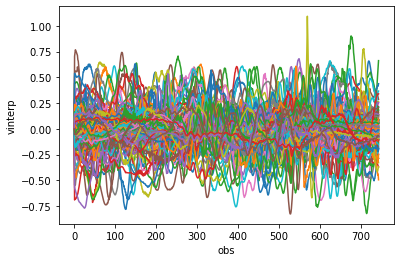

In [4]:
# conversion factor:
cconv=1852.*60.

# apply
v_convert = cconv*prodp['vinterp']

# plot for quick check
for itr in range(0,Np):
        v_convert.isel(traj=itr).plot()

* __convert u to from deg/s to m/s:__

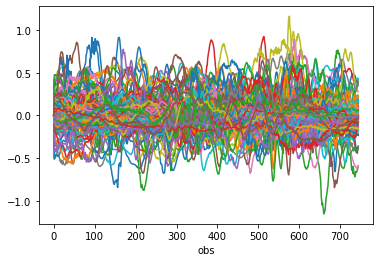

In [5]:
# apply conversion factor
u_convert = cconv*prodp['uinterp']
lattruc = (np.pi/180.)*prodp['lat']
latconv = np.cos(lattruc)
u_convert = u_convert*latconv

# plot for quick check:
for itr in range(0,Np):
        u_convert.isel(traj=itr).plot()

* __rewrite file with units for currents in deg/s and additionnal variable u,v in m/s:__

In [6]:
# add 'units' attributes
prodp.uinterp.attrs['units']='deg/s'
prodp.vinterp.attrs['units']='deg/s'

In [ ]:
# output file name
outfi=filo+"_c"

# save
if (newset):
    prodp.to_netcdf(diro+outfi+'.nc',mode='w')
else:
    # if time segment not first one, skip first timestep as it is the same as last one of the previous segment
    prodp.isel(obs=slice(1,Nobs)).to_netcdf(diro+outfi+'.nc',mode='w') 
    

In [ ]:
# add attributes  for new variable u_convert (u converted in m/s)
u_convert.name='u_convert'
u_convert.attrs['standard_name']='u'
u_convert.attrs['units']='m/s'
u_convert.attrs['long_name']='zonal current at particle location'
# save
if (seg>0):
    # if time segment not first one, skip first timestep as it is the same as last one of the previous segment
    u_convert.isel(obs=slice(1,Nobs)).to_netcdf(diro+outfi+'.nc',mode='a')   
else:
    u_convert.to_netcdf(diro+outfi+'.nc',mode='a')

# add attributes  for new variable u_convert (u converted in m/s)
v_convert.name='v_convert'
v_convert.attrs['standard_name']='v'
v_convert.attrs['units']='m/s'
v_convert.attrs['long_name']='meridional current at particle location'
# save
if (seg>0):
    v_convert.isel(obs=slice(1,Nobs)).to_netcdf(diro+outfi+'.nc',mode='a')   
else:
    v_convert.to_netcdf(diro+outfi+'.nc',mode='a')